<a href="https://colab.research.google.com/github/Giovanni-Zara/grapevine-berries-anomaly-detection-with-SAM-using-zero-shot-learning/blob/main/Progetto_tesi_Zara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#WORKFLOW


# Analyze data - Exploratory Data Analysis (EDA)
* Regression of Classification?
* What is the target variable?
* Is the data unbalanced?
* What are the features? Correlation, ranges, variances, values, NaN, errors…
* Plot to make findings clearer
# Define the relevant metrics to be used
# Train a first baseline algorithm as a reference, e.g.:
* For regression, train a model with all the features
* For classification test basic models as the one-class-classifier (always the same class) and the
basic logistic regression with all the features
* If there is already a State of the Art solution, use it as an additional baseline
# Prepare data (where needed):
* cleaning (e.g. remove NaN, outliers, …)
* normalization
* shuffling and train, test and validation set construction
## check the statistical properties of the splits
* Design experiments and define hyperparameters
* Repeat until performance on the test set is acceptable:
* Train model and cross validate hyper parameters until acceptable performance on training set
is achieved
* Test best hyper parameter model and check if there is overfitting or underfitting
* Final Evaluation: ablation studies and failure modes

In [1]:
#!jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

#PROJECT STRUCTURE

I've decided to structure my project in two different big sections.

* <b>In the first one</b> I'm going to test my dataset with [Lang SAM](https://github.com/luca-medeiros/lang-segment-anything), a sam-based model that allows to segment an image from a quite specific text prompt.
<br>I will test the zero-shot performance of the model and the reliability of the text prompt to resolve anomaly detection problems on my dataset.<br>
I will be processing all the images with this model, then calculating the accuracy and the metrics scores of it, trying to detect anomalies trought prompt

* However interesting and useful (specially for real-time anomaly detection issues) the first approach is, its performances aren't much good.
<br>Given that, <b>in the second section</b> I'm going to to develop an anomaly detection algorithm using SAM as a base to preprocess images, following these steps:
<br>1)<b>Preprocessing</b>:
Prepare the dataset, ensuring I have images that contain normal and anomalous instances and removing the non important samples(Nan, non-images, outliers ...)
<br>2)<b>Segmentation with SAM</b>:
Use SAM to segment objects within the images. This will help in isolating objects of interest from the background.
<br>3)<b>Feature Extraction</b>:
Extract features from the segmented objects, applying feature extraction techniques to obtain detailed features.
<br>4)<b>Anomaly Detection</b>:
Use the extracted features to train an anomaly detection model. This could involve traditional machine learning methods (like isolation forests, one-class SVM) or deep learning-based approaches (like autoencoders, GANs).
<br>5)<b>Evaluation</b>:
Evaluate the performance of your anomaly detection algorithm using appropriate metrics (like precision, recall, F1-score) on a test set containing both normal and anomalous instances.

# Import Segment Anything(SAM) model

---





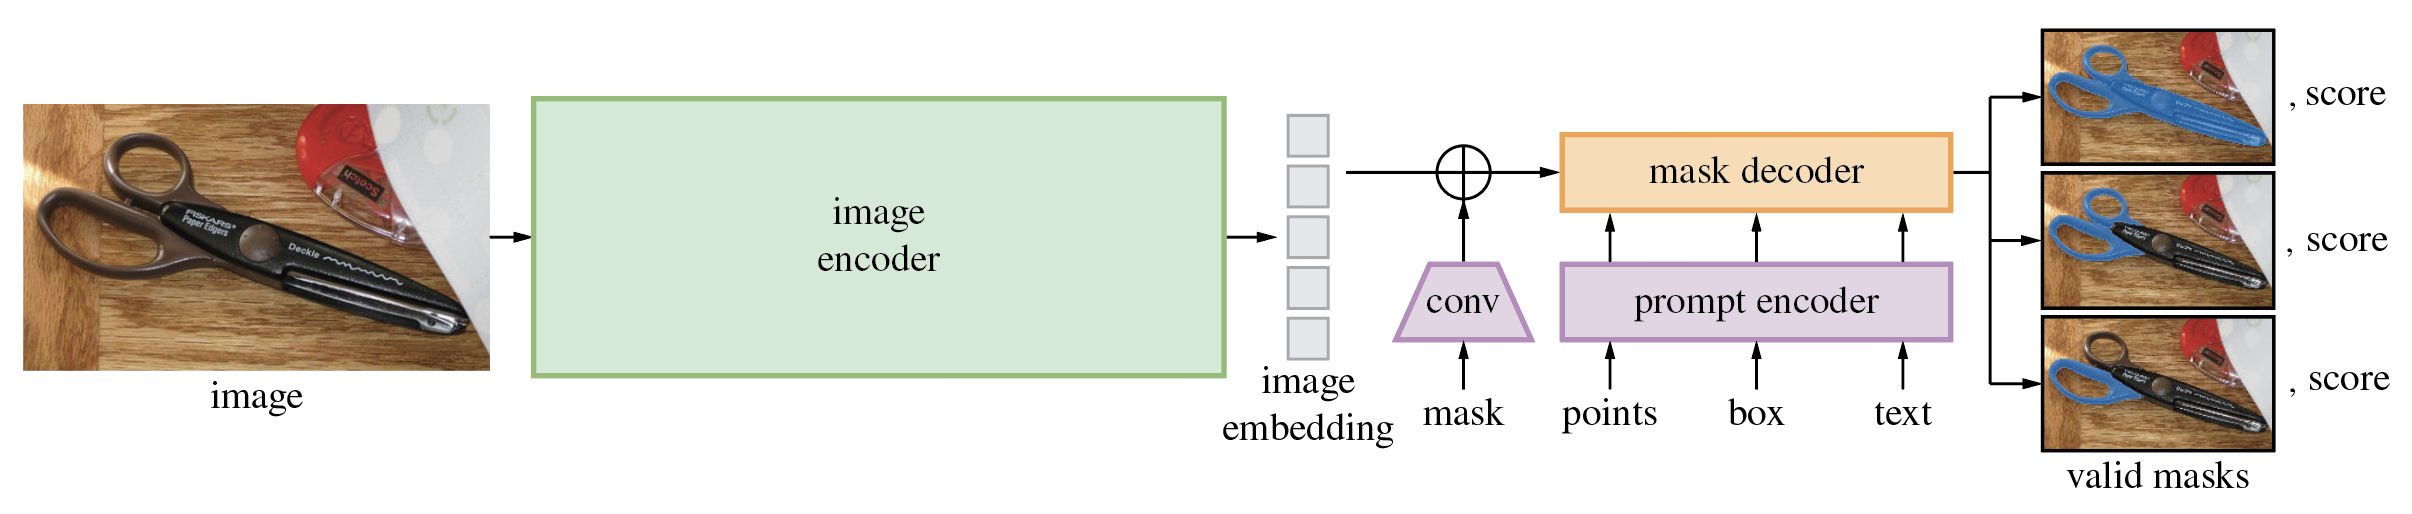

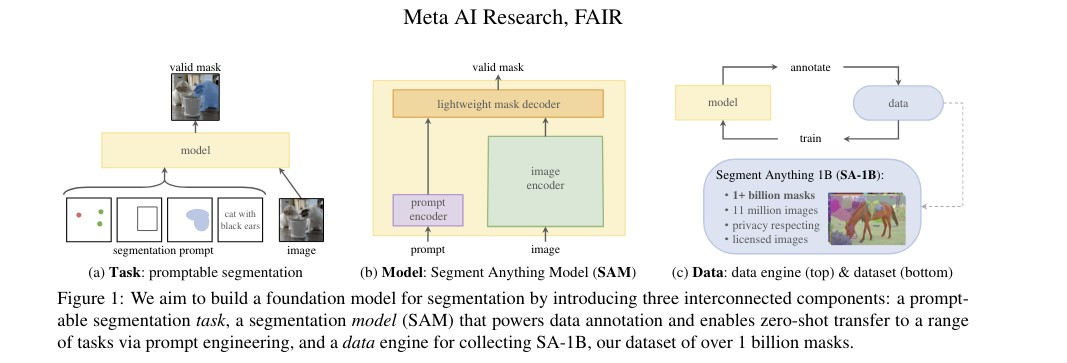

<b>Segment Anything technology</b>, which focuses on identifying and segmenting objects within images, can be very useful in anomaly detection algorithms. Here’s how:

* Accurate Object Localization:

 Segment Anything technology can precisely locate and outline objects in an image. In anomaly detection, having a detailed understanding of where objects are and what they look like when they are normal is crucial for identifying deviations or anomalies.

* Feature Extraction:

 The segmented objects can be used to extract specific features (such as shape, color, texture) that are important for defining what constitutes normality. Anomalies can then be detected by identifying objects whose features significantly deviate from the established normal features.

* Background-Foreground Separation:

 By segmenting objects, the algorithm can separate the relevant foreground objects from the background. Anomalies are often small changes in the foreground that might be missed if the background noise is not properly managed.

* Focused Analysis:

 Instead of analyzing the entire image, the algorithm can focus on the segmented regions of interest. This makes the detection process more efficient and potentially more accurate, as the algorithm does not waste resources on irrelevant parts of the image.


In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git


Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
%cd segment-anything/
!pip install -e .

/content/segment-anything
Obtaining file:///content/segment-anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [3]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


## importing pythorch vision audio with cuda

In [4]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    #!mkdir images
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    #!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: False


## Loading of the SAM mask autoencoder model
SAM provides three different model types as MAE(mask autoencoder) pre-trained Vision Transformer (ViT):
* vit-b (base dimension)
* vit-l (large dimension)
* vit-h (huge dimension)

The models are the same except for the neural network size, respectively little-large-huge.

I've chosen the vit-h SAM model as encoder, seen that (as reported in the paper) it has the best performances compared with the large and small version.


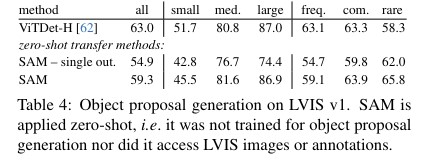

In [5]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
file_path = '/content/segment-anything/sam_vit_h_4b8939.pth'

--2024-07-01 13:39:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   109MB/s    in 31s     

2024-07-01 13:39:48 (77.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint=file_path)

#Data Processing

##importing datas from drive

In [7]:
import os
import torch
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive',force_remount=True)
DATA_DIR = os.path.join("drive", "MyDrive", "canopies_dataset")

torch.manual_seed(42)

Mounted at /content/drive


##dataset class

In [14]:
import random
import numpy as np

#classe per la creazione di dataset
class CanopiesDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir, classe = "every", scale = "every"):

    self.root_dir = root_dir
    self.class_names = sorted(os.listdir(root_dir), reverse=True)
    self.image_paths=[]

    for class_name in self.class_names:
      class_dir = os.path.join(root_dir, class_name)
      scale_dirs = os.listdir(class_dir)
      for scale_dir in scale_dirs:
        scale_path = os.path.join(class_dir, scale_dir)
        image_names = os.listdir(scale_path)
        for image_name in image_names:
          if image_name.endswith(".jpg"):
            if "hdr" not in image_name.lower():
              if ( classe == "every" or classe == class_name):
                    if (scale == "every" or scale == scale_dir):
                        image_path = os.path.join(scale_path, image_name)
                        self.image_paths.append((image_path, self.class_names.index(class_name)))

  def __len__(self):
        return len(self.image_paths)

  def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        return image_path, label


def check_index(index, dataset):
  dataset_size = len(dataset)
  if(index > dataset_size):
    raise IndexError("Index out of bounds")
  return 1


def distribution(dataset, titolo):
    labels = np.array(list(zip(*dataset))[1])
    count_0 = np.sum(labels == 0)
    count_1 = len(labels) - count_0
    labels_count = np.array([count_0, count_1])
    class_names = ["good", "bad"]

    plt.figure(figsize=(8, 4))
    plt.title('Data distribution of '+ titolo)
    plt.bar(class_names, labels_count, width=.5, color = ['C0', 'C1'])
    plt.show()
    print(labels_count)


In [15]:
# Create an instance of the CanopiesDataset
root_dir="/content/drive/MyDrive/first_dataset"
dataset = CanopiesDataset(root_dir, classe="every", scale="every")

# Check the number of images in the dataset
print(f"Total number of images: {len(dataset)}")

Total number of images: 1282


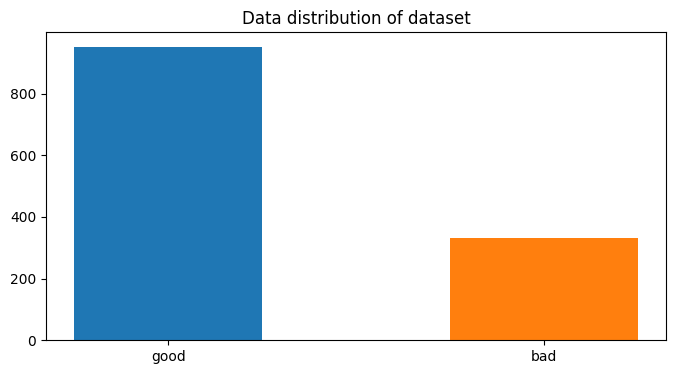

[951 331]


In [16]:
distribution(dataset,"dataset")

##train-validation-test set splitting function

In [20]:
import random
from torch.utils.data import Subset

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits the dataset into training, validation, and test sets.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to split.
        train_ratio (float): The proportion of the dataset to include in the training set.
        val_ratio (float): The proportion of the dataset to include in the validation set.
        test_ratio (float): The proportion of the dataset to include in the test set.

    Returns:
        tuple: A tuple containing the training, validation, and test subsets.
    """
    epsilon = 1e-10  # Small epsilon to handle floating-point precision issues
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < epsilon, "Ratios must sum to 1"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)
    val_end = train_end + int(val_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, val_subset, test_subset


##dataloaders function

In [21]:
from torch.utils.data import DataLoader

def create_dataloaders(train_subset, val_subset, test_subset, batch_size=32):
    """
    Creates DataLoader objects for training, validation, and test sets.

    Args:
        train_subset (torch.utils.data.Dataset): The training subset.
        val_subset (torch.utils.data.Dataset): The validation subset.
        test_subset (torch.utils.data.Dataset): The test subset.
        batch_size (int): The number of samples per batch to load.

    Returns:
        tuple: A tuple containing DataLoader objects for the training, validation, and test sets.
    """
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


##now splitting and loading

In [30]:
train_subset, val_subset, test_subset = split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)
train_loader, val_loader, test_loader = create_dataloaders(train_subset, val_subset, test_subset, batch_size=32)

##datas distribution

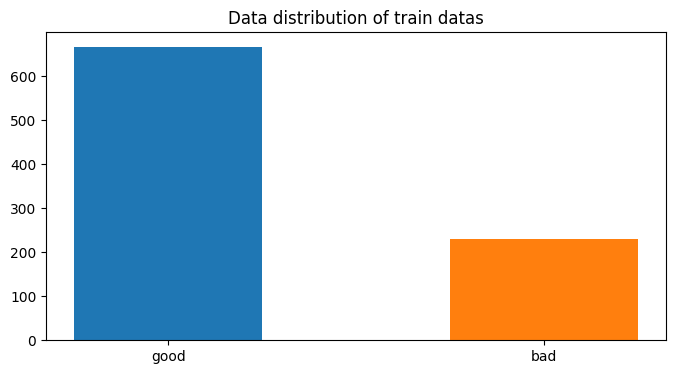

[666 231]


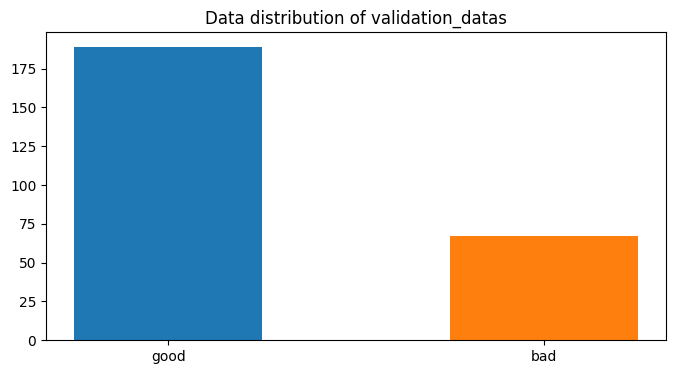

[189  67]


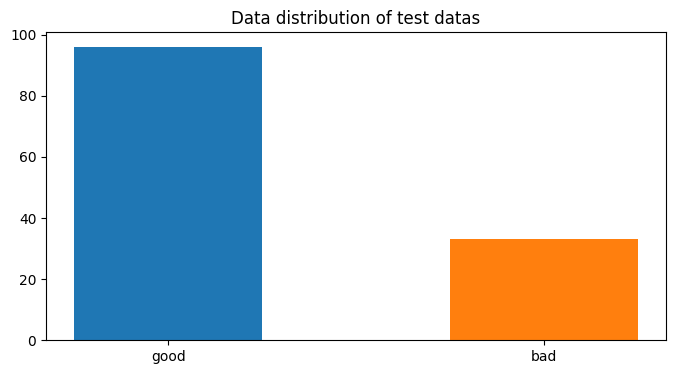

[96 33]


In [26]:
distribution(train_subset, "train datas")
distribution(val_subset, "validation_datas")
distribution(test_subset, "test datas")

# First approach:

## Lang Segment Anything implementation
Language Segment-Anything is an open-source project that combines the power of instance segmentation and text prompts to generate masks for specific objects in images. Built on the Meta model, segment-anything, and the GroundingDINO detection model, it's an easy-to-use and effective tool for object detection and image segmentation.

##Lang SAM setup

In [31]:
!git clone https://github.com/luca-medeiros/lang-segment-anything
%cd lang-segment-anything
#!pip install torch torchvision
!pip install -e .

Cloning into 'lang-segment-anything'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 234 (delta 74), reused 58 (delta 58), pack-reused 134
Receiving objects: 100% (234/234), 13.23 MiB | 27.20 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/segment-anything/lang-segment-anything
Obtaining file:///content/segment-anything/lang-segment-anything
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-install-do4iem8k/groundingdino_0eaf70baa08b4ec4b0599588f04d4ee9
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-install-do4iem8k/groundingdino_0eaf70baa08b4ec4b0599588f04d4ee9
  Resolved htt

In [43]:
# Install Miniconda
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# Update conda
!conda install -q -y --prefix /usr/local python=3.8

# Initialize conda
!conda init

# Update the system path
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')

# Create the environment from environment.yml
!conda env create -f environment.yml

# Activate the new environment
import subprocess
subprocess.run(['source', 'activate', 'lsa'], shell=True)


--2024-07-01 15:30:46--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146836934 (140M) [application/octet-stream]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 140.03M  37.0MB/s    in 3.9s    

2024-07-01 15:30:50 (36.0 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [146836934/146836934]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHON

CompletedProcess(args=['source', 'activate', 'lsa'], returncode=127)

###utils and funcions to display masks and metrics

In [ ]:
def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def visualize_saved_masks(num_masks):
    for i in range(1, num_masks + 1):
        mask_path = f"image_mask_{i}.png"
        mask_img = Image.open(mask_path)

        plt.figure(figsize=(8, 8))
        if mask_img.mode == 'RGBA':
            # If masks have an alpha channel, remove it for display
            mask_img = mask_img.convert('RGB')

        plt.imshow(mask_img)  # Display as RGB (or whatever the mode is)
        plt.title(f"Mask {i}")
        plt.axis('off')
        plt.show()

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")


##example of how I'm processing the dataset
I've created an array of seven different text prompts that seem to be the most efficient ones.
In the following example I submit one image to the processing, to generate seven different boxed detections(one for each prompt).
<br>I will cross validate these seven different outputs to obtain a more efficient and reliable detection of the anomaly.

I will consider as reliable just the processings that share a certain amount of same or similar boxes, that to contain the error and try to fix the poor performance of the model on good samples (healthy grapes)

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


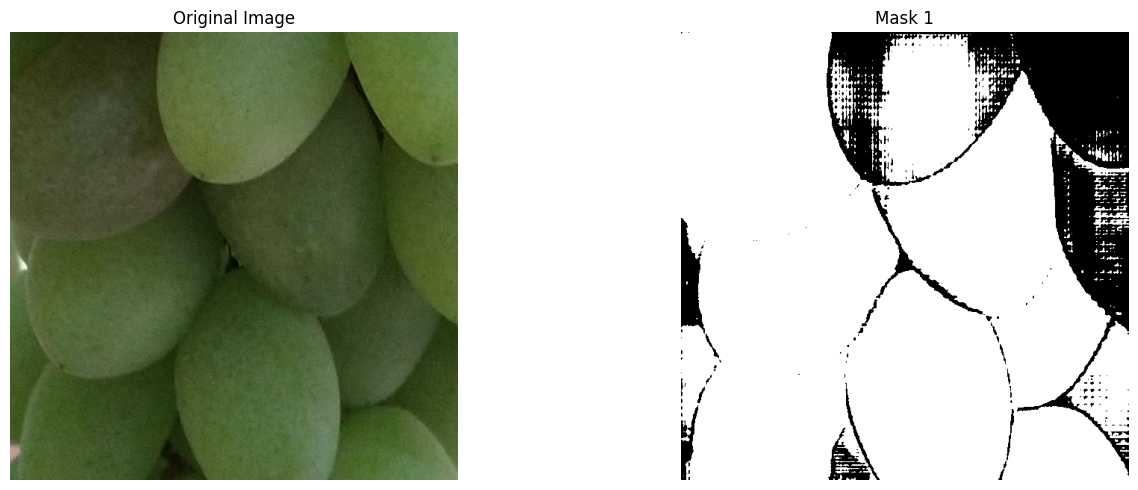

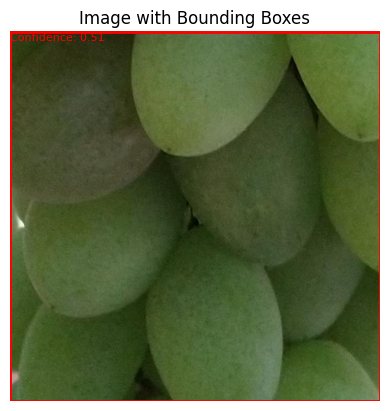

Bounding Boxes:
Box 1: tensor([1.8382e-02, 5.7220e-04, 6.0002e+02, 6.0000e+02])

Detected Phrases:
Phrase 1: rotten

Confidence:
Logit 1: 0.512016773223877
------------------------------------------------------------

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


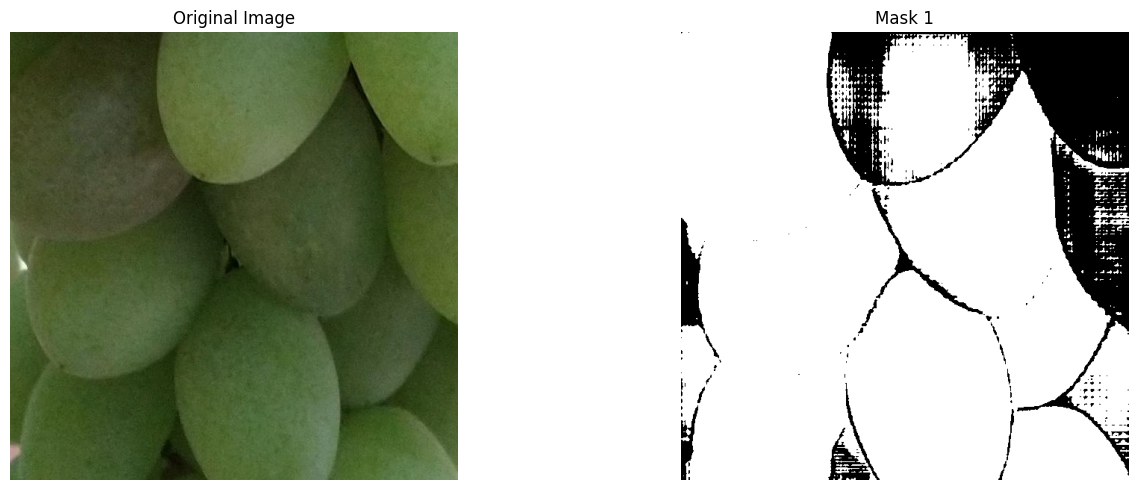

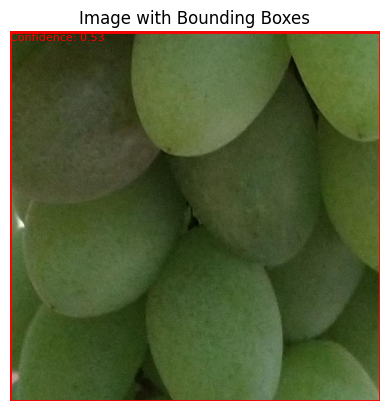

Bounding Boxes:
Box 1: tensor([-3.5405e-03,  7.0810e-03,  6.0000e+02,  6.0001e+02])

Detected Phrases:
Phrase 1: sick

Confidence:
Logit 1: 0.5320708155632019
------------------------------------------------------------

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


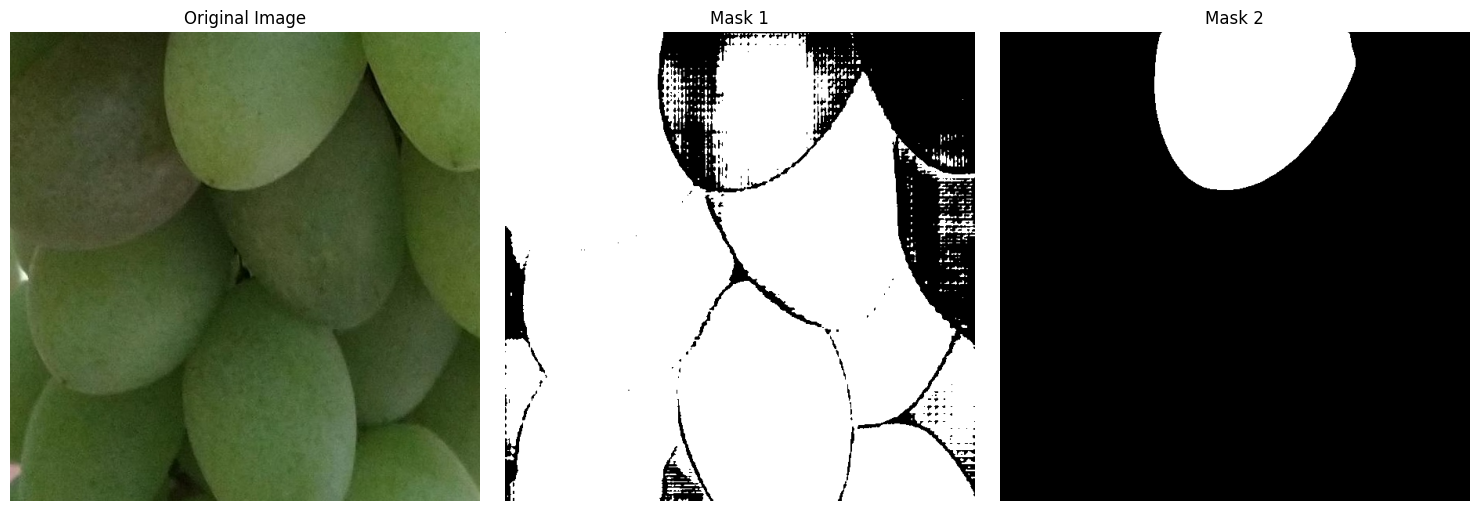

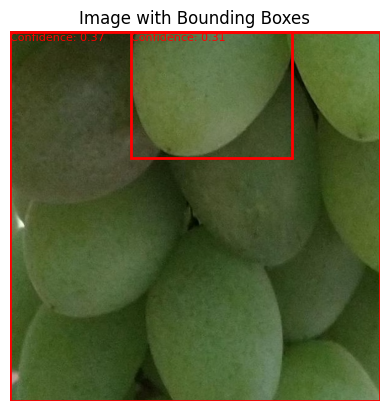

Bounding Boxes:
Box 1: tensor([1.9813e-02, 6.6233e-02, 6.0002e+02, 6.0006e+02])
Box 2: tensor([1.9517e+02, 1.1548e-01, 4.5654e+02, 2.0521e+02])

Detected Phrases:
Phrase 1: moldy
Phrase 2: moldy

Confidence:
Logit 1: 0.37174534797668457
Logit 2: 0.30869272351264954
------------------------------------------------------------

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


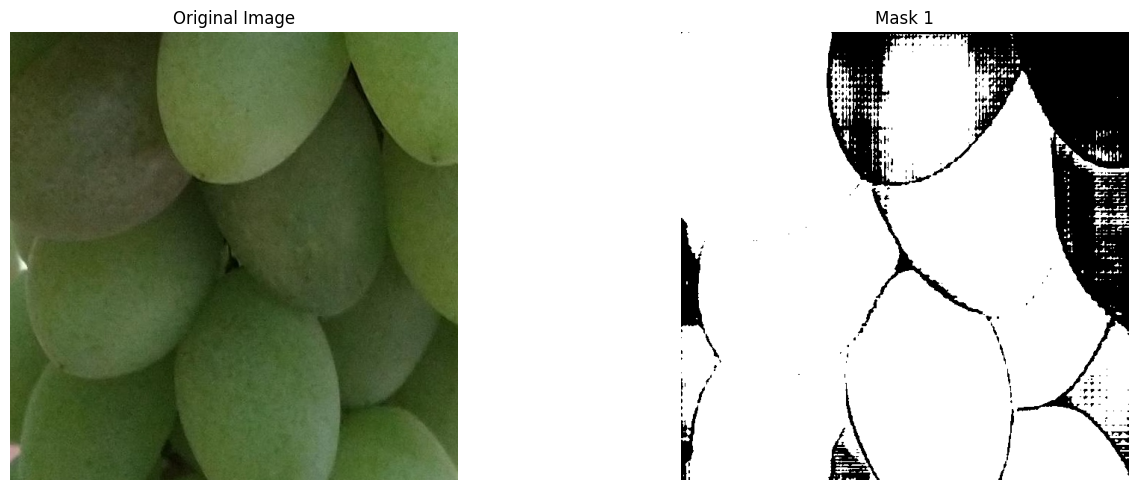

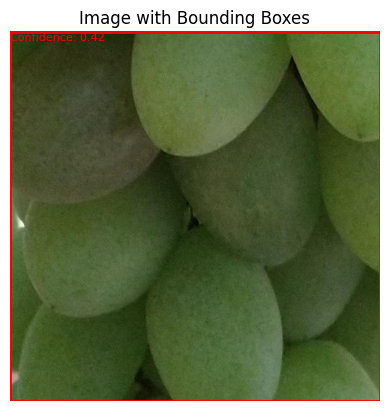

Bounding Boxes:
Box 1: tensor([1.8632e-02, 6.6411e-02, 6.0002e+02, 6.0006e+02])

Detected Phrases:
Phrase 1: rancid

Confidence:
Logit 1: 0.4156014323234558
------------------------------------------------------------

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


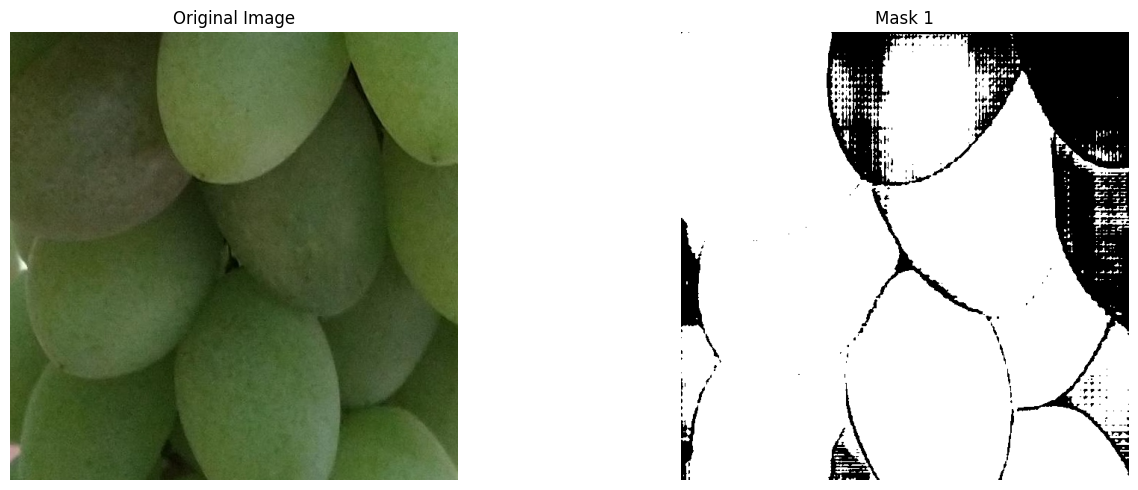

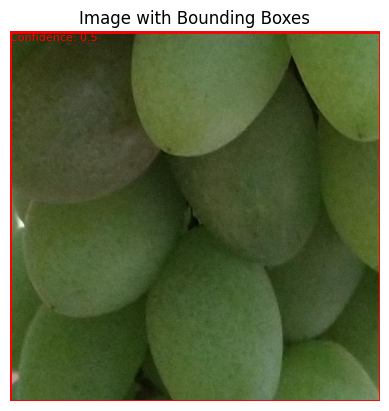

Bounding Boxes:
Box 1: tensor([1.4234e-02, 4.3738e-02, 6.0001e+02, 6.0004e+02])

Detected Phrases:
Phrase 1: putrid

Confidence:
Logit 1: 0.4952641725540161
------------------------------------------------------------

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


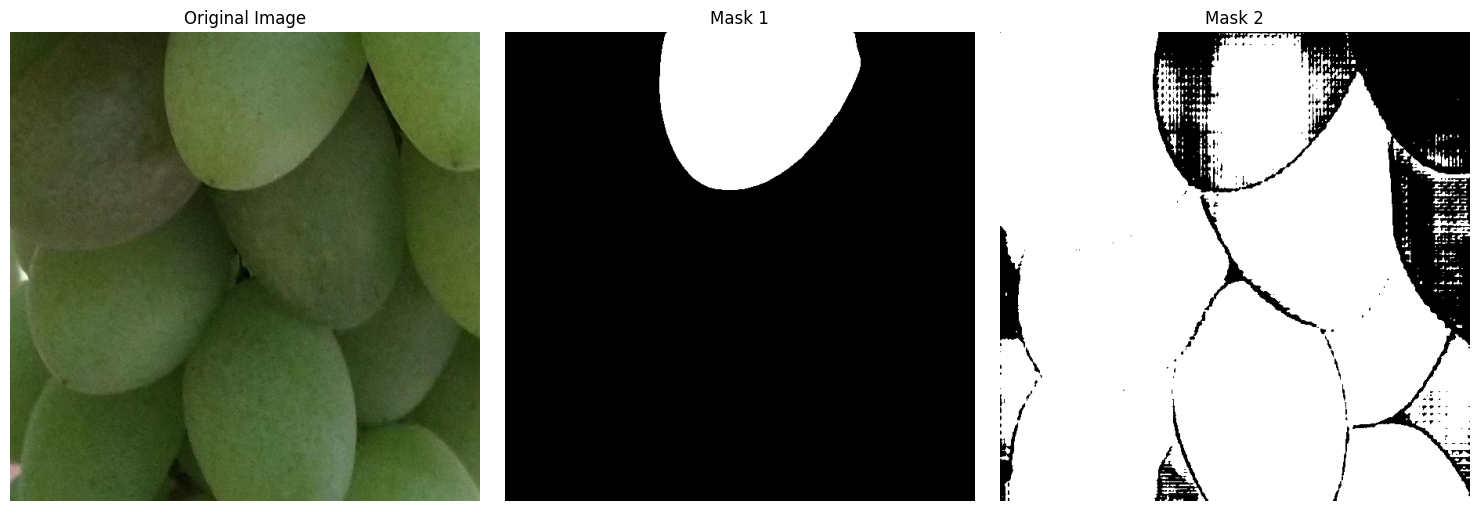

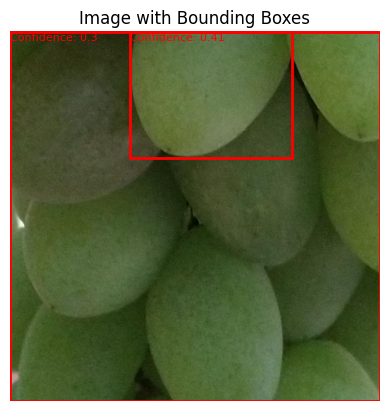

Bounding Boxes:
Box 1: tensor([1.9482e+02, 1.3196e-01, 4.5675e+02, 2.0573e+02])
Box 2: tensor([-4.2701e-02, -4.4882e-02,  5.9996e+02,  5.9995e+02])

Detected Phrases:
Phrase 1: bad
Phrase 2: bad

Confidence:
Logit 1: 0.40814054012298584
Logit 2: 0.30346545577049255
------------------------------------------------------------

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


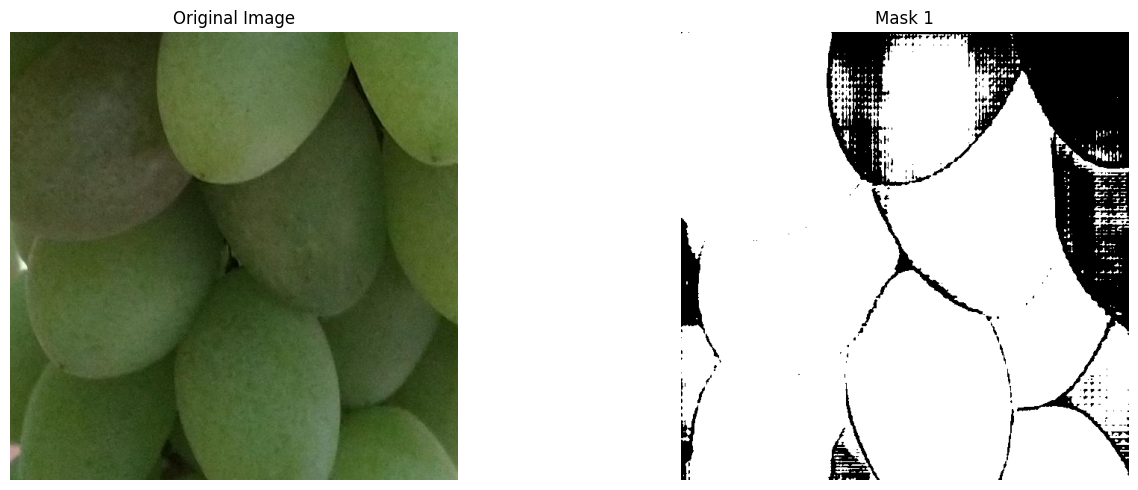

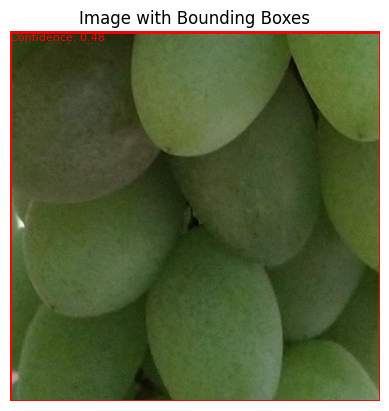

Bounding Boxes:
Box 1: tensor([-7.2956e-03,  6.5947e-02,  5.9999e+02,  6.0006e+02])

Detected Phrases:
Phrase 1: decomposed

Confidence:
Logit 1: 0.47622033953666687
------------------------------------------------------------



In [64]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

model = LangSAM() #model initialisation

image = "/content/drive/MyDrive/first_dataset/bad/scale_2/IMG_20210924_132434569_00.jpg"  #bad example image


prompts=["rotten", "sick","moldy","rancid","putrid","bad","decomposed"]

for i in range(len(prompts)):
  text_prompt = prompts[i]

      # Suppress warning messages
  warnings.filterwarnings("ignore")

  try:
      if image.startswith("http"):
          image_pil = download_image(image)
      else:
          image_pil = Image.open(image).convert("RGB")

      masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

      if len(masks) == 0:
          print(f"No objects of the '{text_prompt}' prompt detected in the image.")
      else:
          # Convert masks to numpy arrays
          masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

          # Display the original image and masks side by side
          display_image_with_masks(image_pil, masks_np)

          # Display the image with bounding boxes and confidence scores
          display_image_with_boxes(image_pil, boxes, logits)

          # Save the masks
          for i, mask_np in enumerate(masks_np):
              mask_path = f"image_mask_{i+1}.png"
              save_mask(mask_np, mask_path)

          # Print the bounding boxes, phrases, and logits
          print_bounding_boxes(boxes)
          print_detected_phrases(phrases)
          print_logits(logits)
          print("------------------------------------------------------------\n")
  except (requests.exceptions.RequestException, IOError) as e:
      print(f"Error: {e}")



In [ ]:
import torch
from itertools import combinations

def compare_tensors_within_epsilon(tensor1, tensor2, epsilon=1e-5):
    # Assuming tensor1 and tensor2 are tensors of shape (4,) representing (x_min, y_min, x_max, y_max)
    if (torch.abs(tensor1 - tensor2) <= epsilon).all():
        return True
    else:
        return False

def flag_image_as_good(tensors, epsilon=1e-5, min_similar=3):
    num_tensors = len(tensors)
    count_good = 0

    # Iterate through combinations of tensors
    for combo in combinations(range(num_tensors), 2):
        idx1, idx2 = combo
        if compare_tensors_within_epsilon(tensors[idx1], tensors[idx2], epsilon):
            count_good += 1

    # Check if at least min_similar tensors are similar
    if count_good >= min_similar:
        return True
    else:
        return False

# Example usage:
tensor1 = torch.tensor([100, 50, 200, 150])  # Coordinates of box 1
tensor2 = torch.tensor([110, 55, 210, 155])  # Coordinates of box 2 (similar to box 1 within epsilon)
tensor3 = torch.tensor([300, 200, 400, 300])  # Coordinates of box 3 (different from box 1 within epsilon)

tensors = [tensor1, tensor2, tensor3]

# Flag image as "good" if at least 3 tensors are similar within epsilon
is_good = flag_image_as_good(tensors, epsilon=10, min_similar=3)

if is_good:
    print("Image is flagged as good.")
else:
    print("Image is not flagged as good.")


##now processing the entire dataset

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

model = LangSAM() #model initialisation
box_list = []

for i in range(len(dataset)):

  image = dataset.__getitem__(i)[0]
  label = dataset.__getitem__(i)[1]
  prompts=["rotten", "sick","moldy","rancid","putrid","bad","decomposed"]

  box_list_temp = []
  for i in range(len(prompts)):
    text_prompt = prompts[i]

        # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")


        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            #display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            #display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            box_list_temp.append(boxes[0])
            # Print the bounding boxes, phrases, and logits
            #print_bounding_boxes(boxes)
            #print_detected_phrases(phrases)
            #print_logits(logits)
            print("------------------------------------------------------------\n")

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")
  #for i in len(box_list_temp):   DA COMPLETARE!!!!!!!!!!!!!!!!!!!!

  print("image processed\n")
  box_list.append((image, label, box_list_temp))#da completare con ultimo elemento che è se almeno 3 tensor sono uguali = 1 -> img cacata



#Second approach

## setting up the automatic mask generator

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

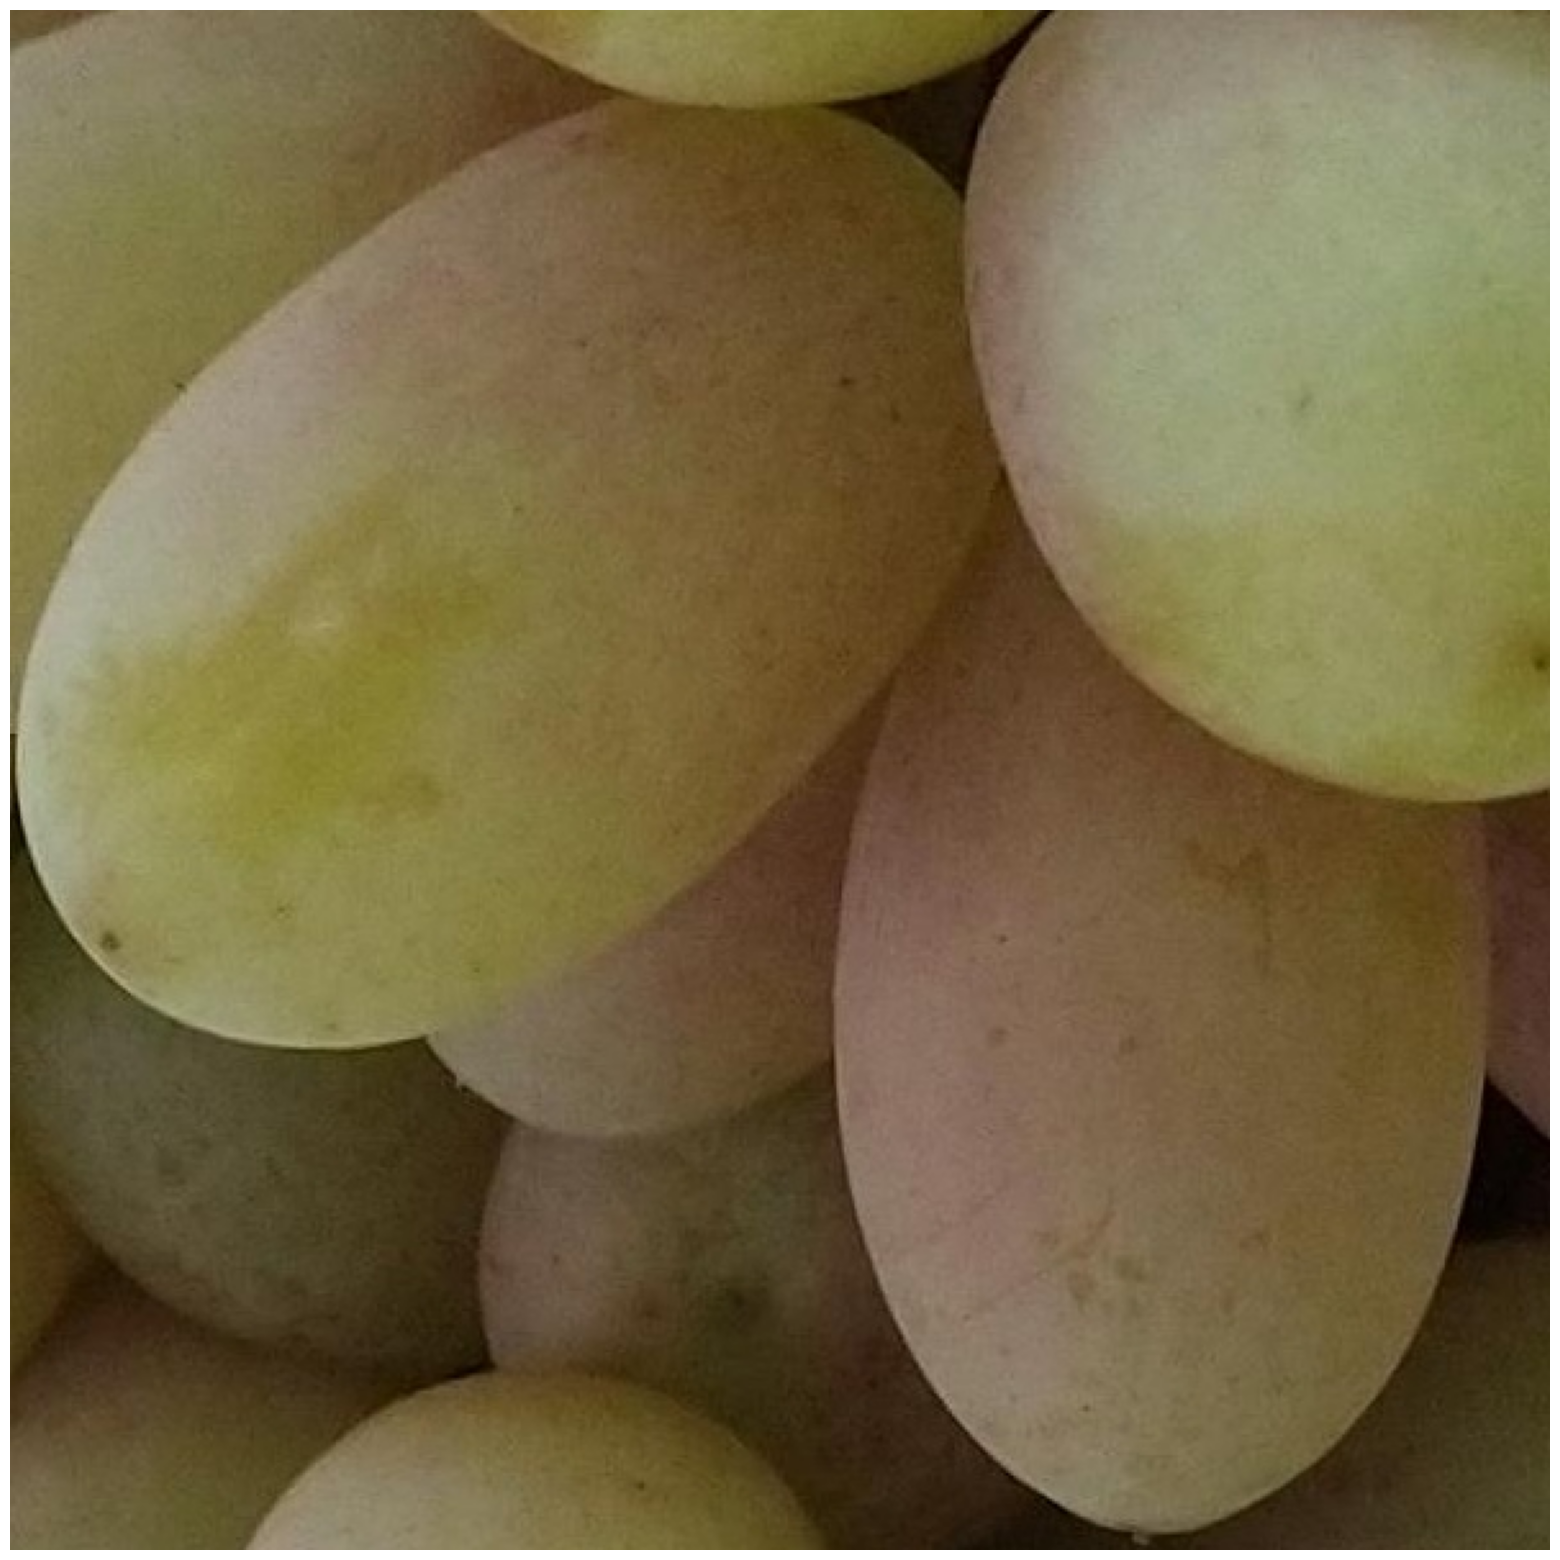

In [65]:
image = cv2.imread('/content/IMG_20210924_121928800_0_00.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [66]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

#sam_checkpoint = "sam_vit_h_4b8939.pth"
#model_type = "vit_h"

device = "cuda"

#sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [67]:
masks = mask_generator.generate(image)

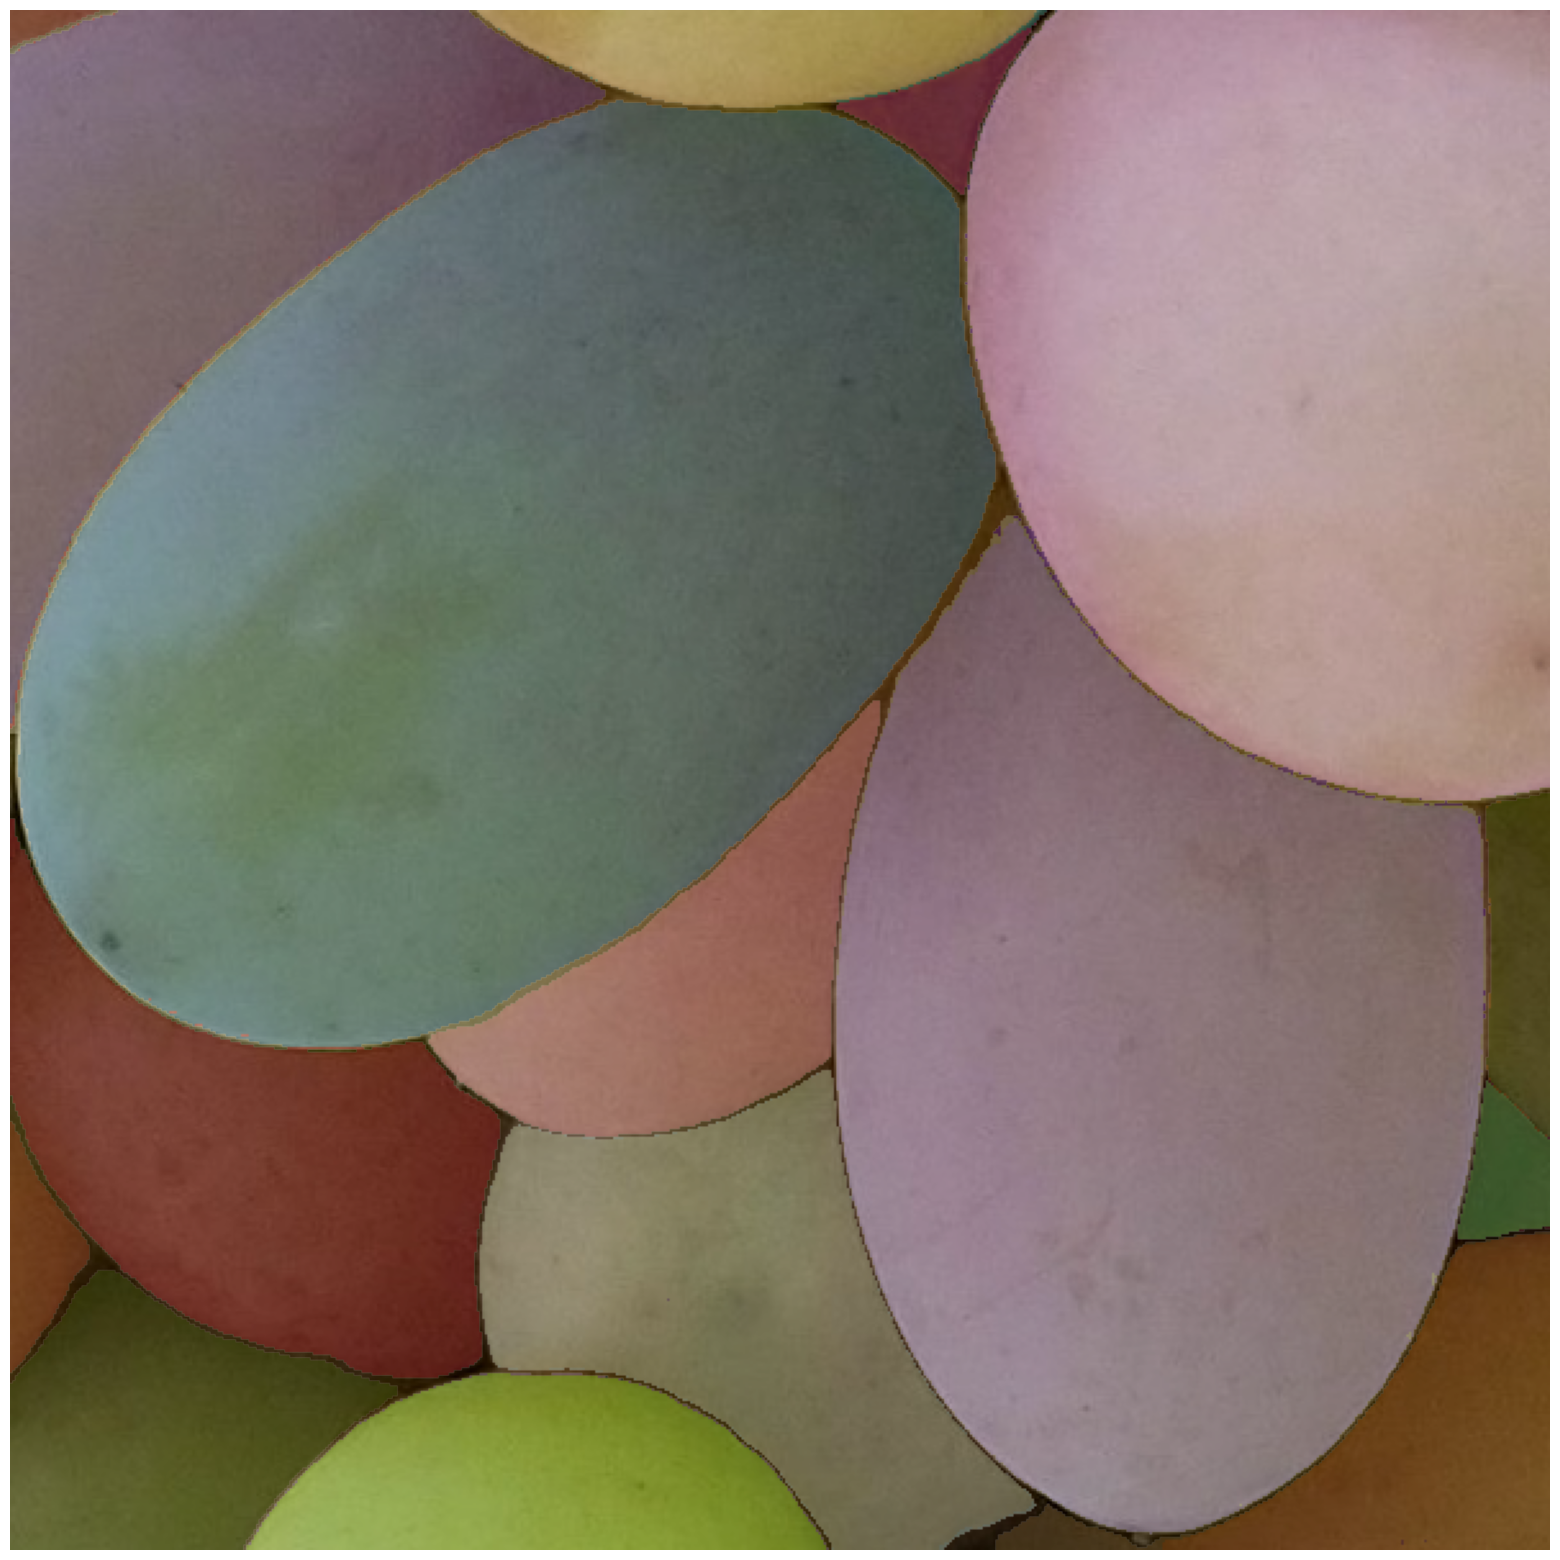

In [68]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
import os
import torch
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive',force_remount=True)
DATA_DIR = os.path.join("drive", "MyDrive", "Canopies-data")